# Getting started

This tutorial will guide you through installing the required libraries for the rest of the tutorials, downloading and accessing the dataset, and loading some data to view.

## Setup your environment

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install jupyter plotly matplotlib nilearn statsmodels himalaya accelerate transformers nltk sentencepiece spacy
!python -m spacy download en_core_web_lg

Now that libraries are installed, we can load them.

In [1]:
import mne
import numpy as np
from mne_bids import BIDSPath

## Download the data

In [5]:
# TODO - download from OpenNeuro

## Verify dataset

Now that we have the dependencies installed and the dataset downloaded, let's make sure we can load the files and work with them. For this, we'll be working with a library called [MNE](https://mne.tools/). Because the dataset is structured according to [BIDS](https://bids-specification.readthedocs.io/en/stable/) conventions, we can use the `BIDSPath` class to help us find specific files.

For now, we want to work the already preprocessed data that is filtered into the high gamma band. This file exists in `derivatives/ecogprep/sub-0*/ieeg/sub-0*_task-monkey_desc-highgamma_ieeg.fif`. The `fif` extension signifies this is an MNE format that contains the data and metadata in one file. Now, we'll use `BIDSPath` and its `match` method to find these files.

In [2]:
edf_path = BIDSPath(root="../../monkey/derivatives/ecogprep",
                    datatype="ieeg",
                    description="highgamma",
                    extension=".fif")
edf_paths = edf_path.match()

print(f"Found {len(edf_paths)} matching paths")
print(f"Second path: {edf_paths[1]}")

Found 9 matching paths
Second path: ../../monkey/derivatives/ecogprep/sub-02/ieeg/sub-02_task-monkey_desc-highgamma_ieeg.fif


Now let's load one of these files using the `read_raw_fif` file, and then display some of the metadata about the file.

In [3]:
raw = mne.io.read_raw_fif(edf_paths[1], verbose=False)
raw

<Raw | sub-02_task-monkey_desc-highgamma_ieeg.fif, 90 x 921600 (1800.0 s), ~108 kB, data not loaded>

The output contains several important pieces of information. First, duration of the data is roughly 30 minutes long (corresponding to the length of the podcast). The data is sampled at 512 Hz. There are 90 ECoG channels. And the data has a filtered applied to it ranging from 70 Hz to 200 Hz.

One of the primary MNE classes is the [Raw](https://mne.tools/stable/generated/mne.io.Raw.html). It has many useful methods and properties if you look at its documentation. The two we will mention now are `get_data()` and the `info` attribute. Sometimes we want to work with the underlying data directly. Here is how:

In [4]:
data = raw.get_data()
print(f"Data is a {type(data)} object and has a shape of: {data.shape}")

Data is a <class 'numpy.ndarray'> object and has a shape of: (90, 921600)


We notice that the data is a NumPy object (a nearly universal way of working with numerical data in python), and its a matrix with two dimensions. The first dimension corresponds to the number of channels—90, as we saw before— and the second is the total number of samples.

`raw.info` returns an [Info](https://mne.tools/stable/generated/mne.Info.html) object. We saw this information earlier as it contains much of the metadata of the file. Particularly useful are the information we can get on those 90 channels. This can be accessed by `raw.info.ch_names` and `raw.info.chs`. The documentation spells out the details very clearly. Below, we'll use the channel information to get electrode locations and plot them on a brain.

For example, let's look at just the first electrode.

In [5]:
print("First channel name is:", raw.info.ch_names[0])
print("Metadata associated with the first channel:")
raw.info['chs'][0]

First channel name is: PO1
Metadata associated with the first channel:


{'scanno': 1,
 'logno': 1,
 'kind': 902 (FIFFV_ECOG_CH),
 'range': 1.0,
 'cal': 1.0,
 'coil_type': 1 (FIFFV_COIL_EEG),
 'loc': array([-0.06466667, -0.051     , -0.01066667,  0.        ,  0.        ,
         0.        ,         nan,         nan,         nan,         nan,
                nan,         nan]),
 'unit': 107 (FIFF_UNIT_V),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'PO1',
 'coord_frame': 4 (FIFFV_COORD_HEAD)}

The `loc` key in the dictionary gives us the 3D coordinates (x, y, and z) that localize the electrode in brain space.

## Ploting electrodes on the brain

Now we'll use a library called [nilearn](https://nilearn.github.io/) to help us plot the electrodes on a glass brain. We'll be using the function [plot_markers](https://nilearn.github.io/stable/modules/generated/nilearn.plotting.plot_markers.html). Take a quick look at its parameters in the documentation, as they can be very useful.

In [6]:
from nilearn.plotting import plot_markers

At a minimum, this function requires a set of values, and a corresponding set of coordinates. The coordinates tell `nilearn` _where_ to plot the electrode, while the value tells it what color to assign it. For the example below, we just want to plot them all in one color, so values will be all the same number. Importantly, we need to collate the coordinates into a NumPy matrix of shape `(n, 3)` where `n` is the number of electrodes and the 3 columns are the coordinates of each electrode. First, we'll assemble this matrix:

In [7]:
ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

Coordinate matrix shape:  (90, 3)


And now we plot them on the brain:

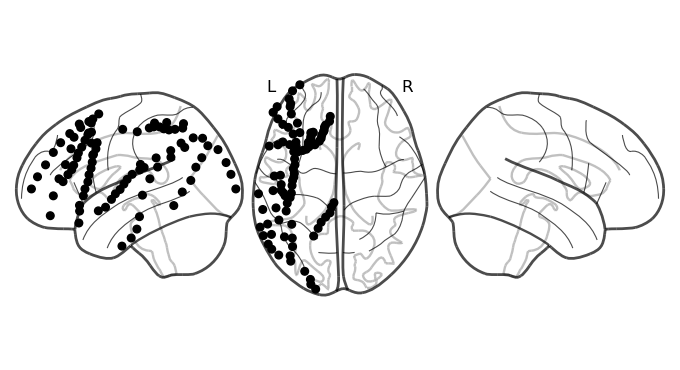

In [8]:
values = np.ones(len(coords))
fig = plot_markers(values, coords,
             node_size=30, display_mode='lzr', alpha=1,
             node_cmap='Grays', colorbar=False, node_vmin=0, node_vmax=1)
print(fig)